In [3]:
import pandas as pd
import numpy as np
from glob import glob
import tskit
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
import time
import emcee
from scipy import linalg
from scipy.optimize import minimize


directory = "."

demes = pd.read_csv(f"{directory}/demes_elev_two_type.tsv", sep="\t")

#demes["type"] = 0 #ignoring elevation type

samples = pd.read_csv(f"{directory}/samples_elev_two_type.tsv", sep="\t")

world_map = tct.WorldMap(demes, samples)

trees = [tct.nx_bin_ts(tskit.load(ts).simplify(), [0, 10, 100, 1000, 10000, 100000, 1000000, 1000000]).first() for ts in glob(f"{directory}/trees/*")]
#trees = [tskit.load(ts).first() for ts in glob(f"{directory}/trees/*")]

cl = []
bal = []
r = []
for tree in trees:
    child_list, branch_above_list, roots = tct.convert_tree_to_tuple_list(tree)
    cl.append(child_list)
    bal.append(branch_above_list)
    r.append(roots)

total_number_of_edges = 0
for tree in trees:
    total_number_of_edges += tree.num_edges+1
branch_lengths = np.zeros(total_number_of_edges, dtype="int64")
edge_counter = 0
for tree in trees:
    for node in tree.nodes(order="timeasc"):
        branch_lengths[edge_counter] = int(tree.branch_length(node))
        edge_counter += 1
branch_lengths = np.unique(np.array(branch_lengths))

In [4]:
%%time
mr = np.array([2.70128820e-02, 9.90743015e-05, 1.01947043e-08])
res = minimize(
    tct.calc_migration_rate_log_likelihood,
    mr,
    method="nelder-mead",
    bounds=[(1e-8, 1), (1e-8, 1), (0, 1)],
    args=(world_map, cl, bal, r, branch_lengths)
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


SystemError: CPUDispatcher(<function _parallel_process_trees at 0x152630400>) returned a result with an exception set

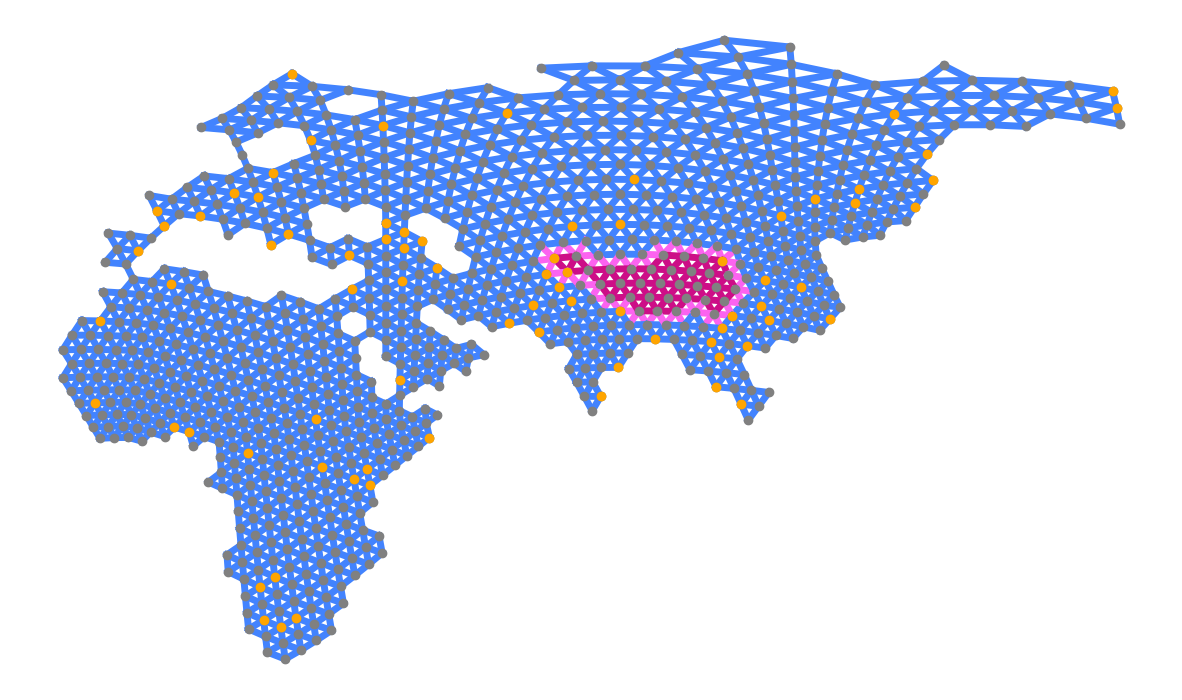

In [2]:
world_map.draw(figsize=(15,15), color_connections=True, show_samples=True)

In [ ]:
[0.02082764] -475831.03117883264 in 36min15s
[2.70423119e-02 9.87494179e-05 1.00000000e-06] in 2h33min12s
[2.70128820e-02 9.90743015e-05 1.01947043e-08]
[2.705e-02  9.901e-05  4.903e-14]

In [13]:
tree = 10
locations = tct.locate_nodes_in_tree(trees[tree], world_map, migration_rates=[2.705e-02, 9.901e-04, 4.903e-14])

Precalculating transitions...


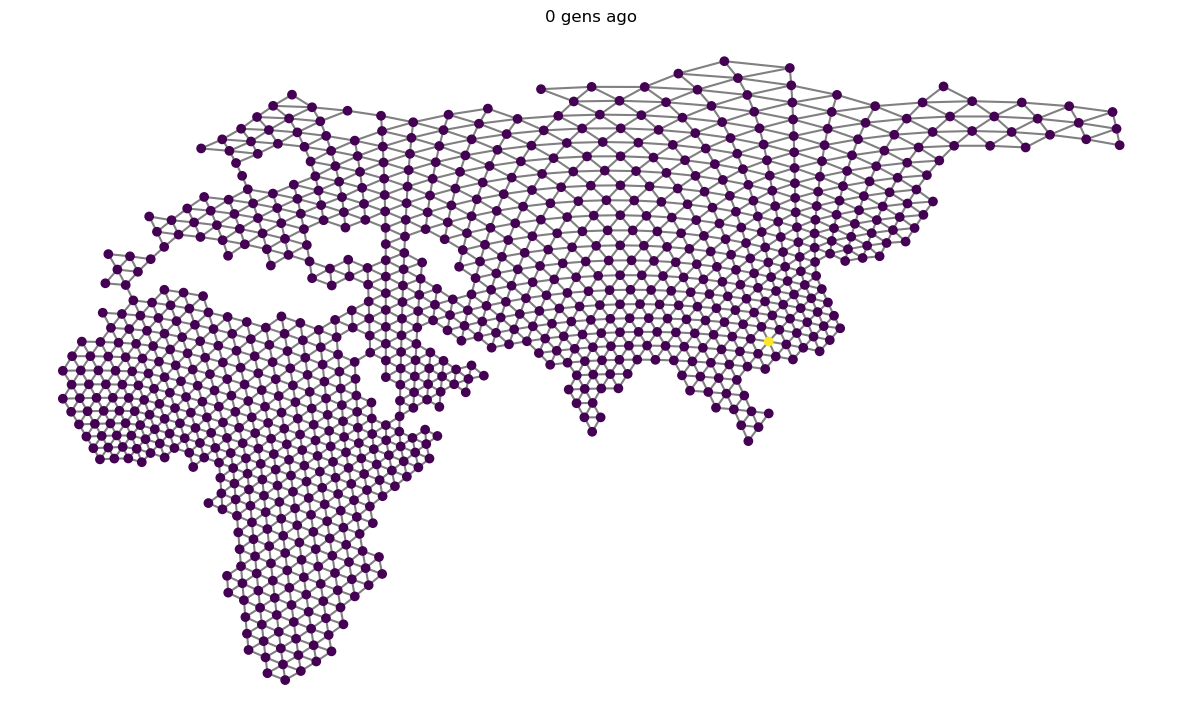

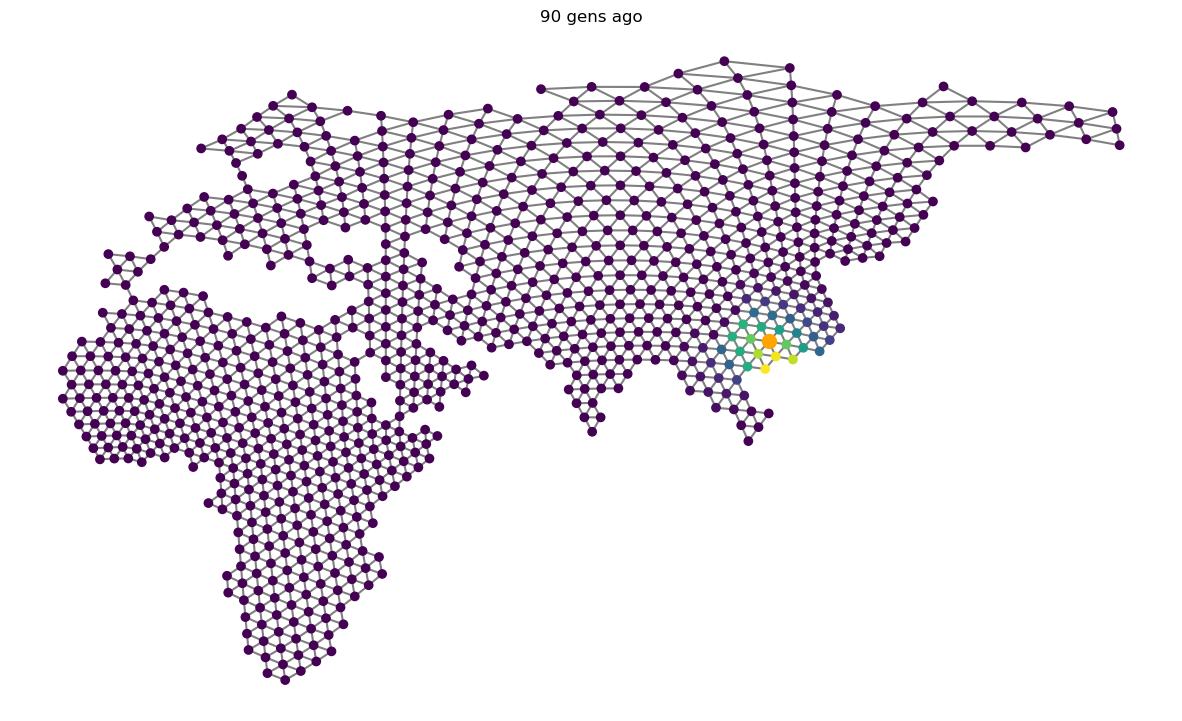

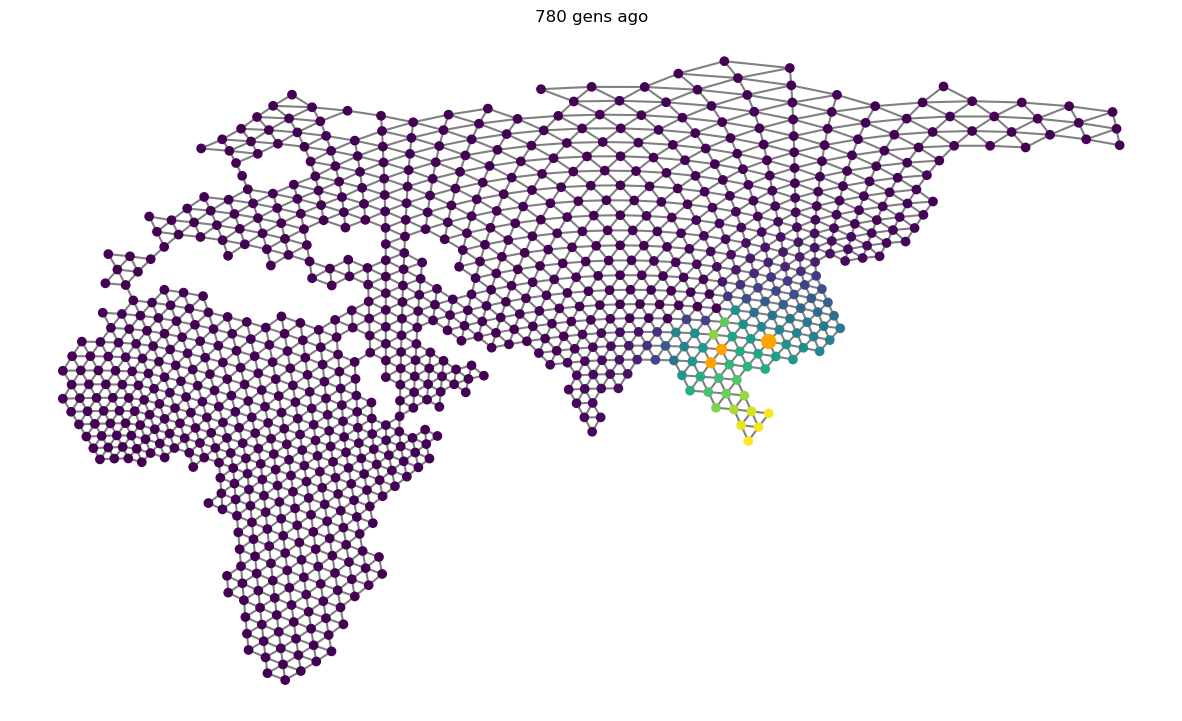

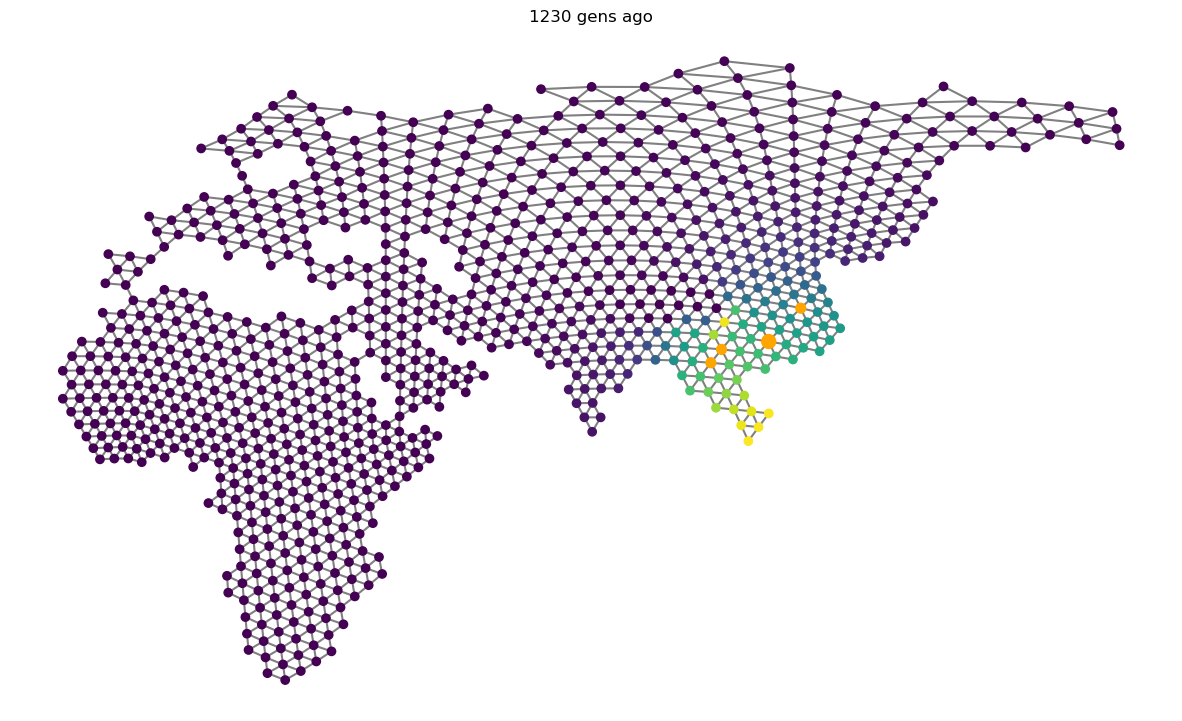

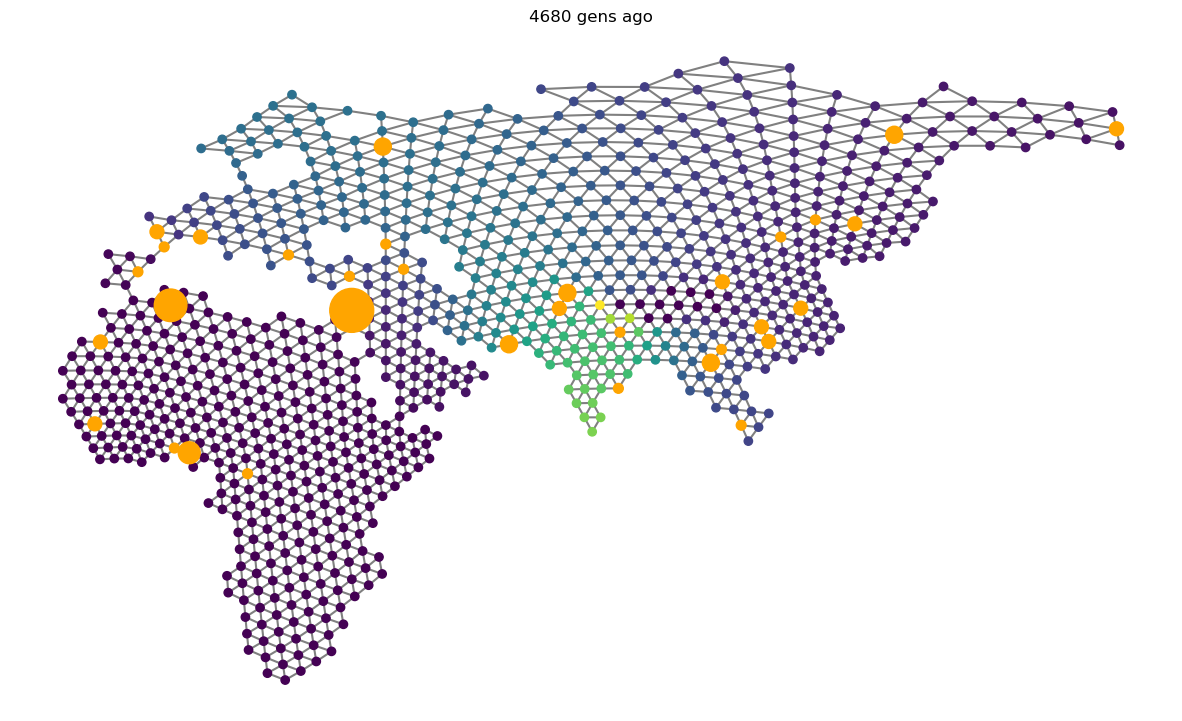

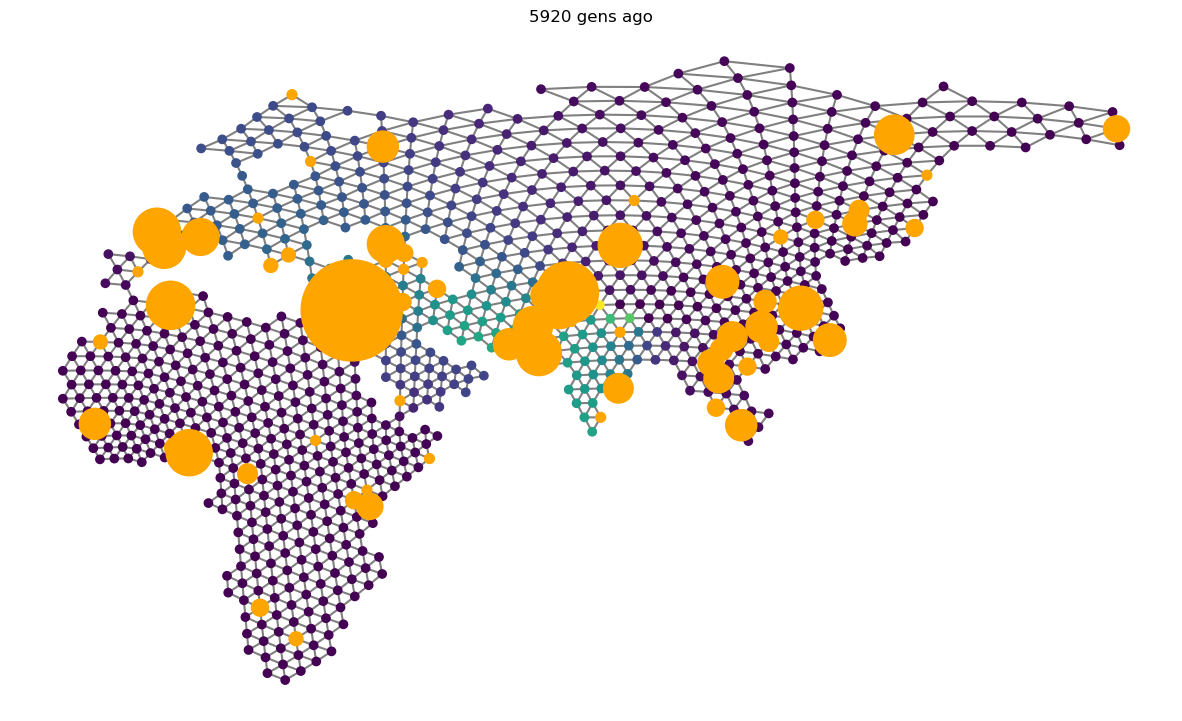

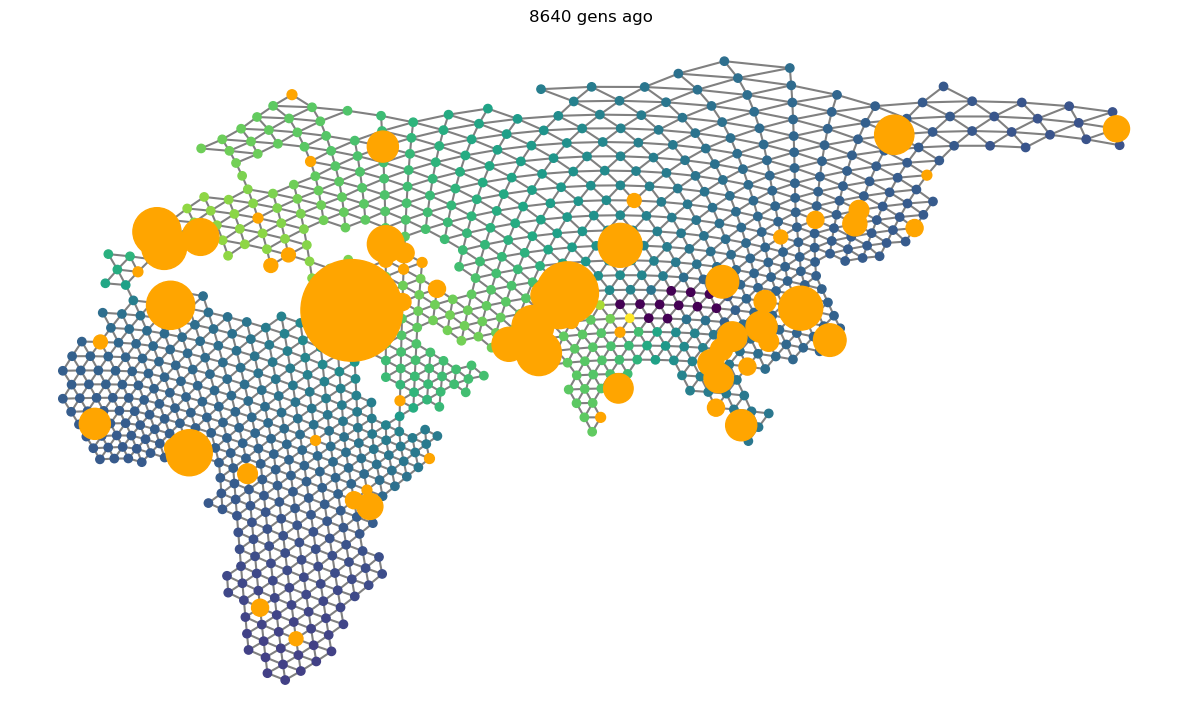

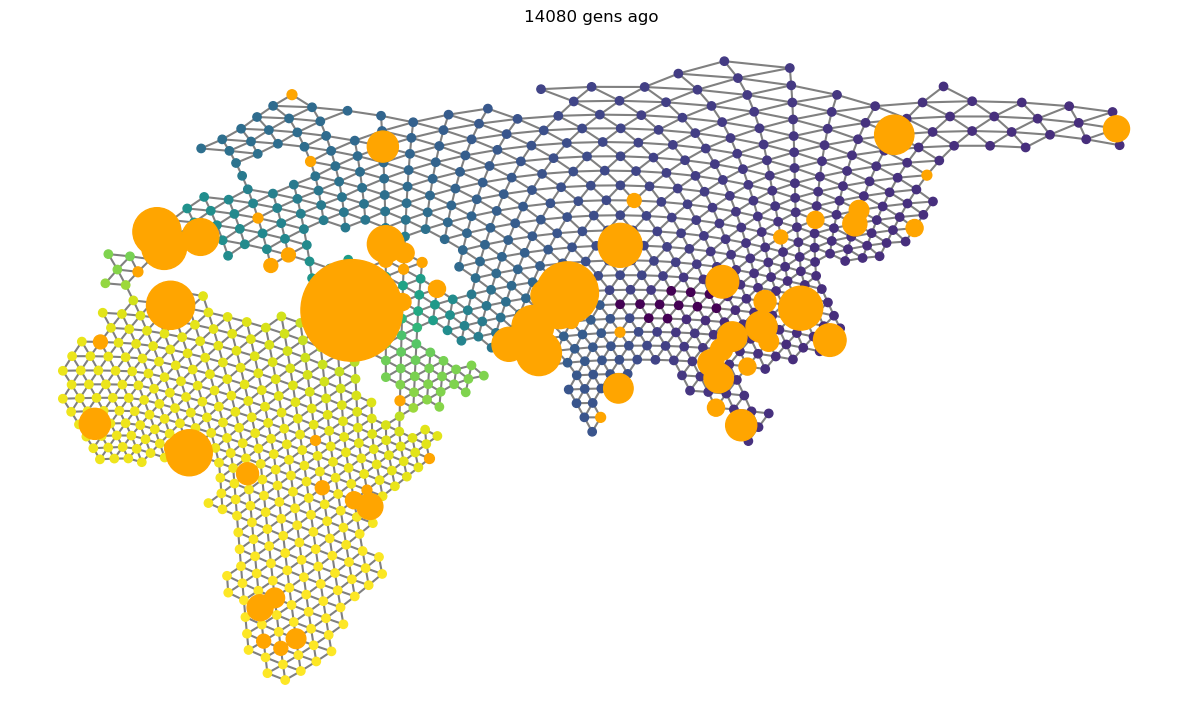

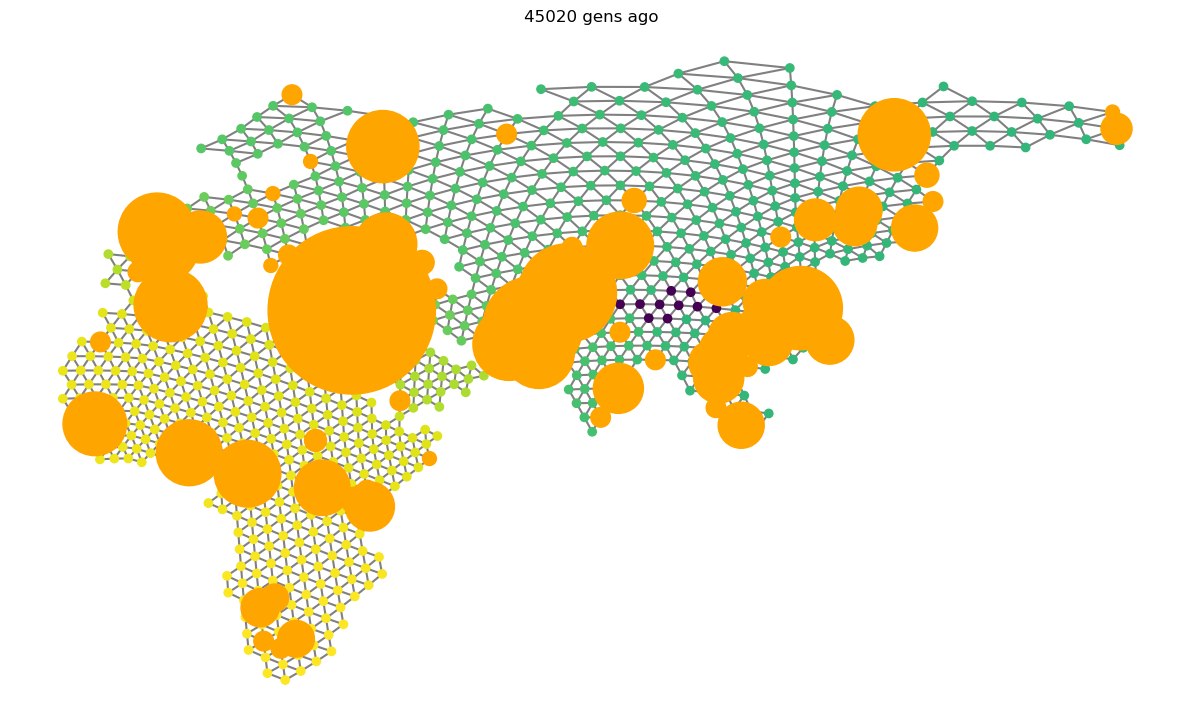

In [ ]:
def ancestors(tree, u):
    """Find all of the ancestors above a node for a tree

    Taken directly from https://github.com/tskit-dev/tskit/issues/2706

    Parameters
    ----------
    tree : tskit.Tree
    u : int
        The ID for the node of interest

    Returns
    -------
    An iterator over the ancestors of u in this tree
    """

    u = tree.parent(u)
    while u != -1:
         yield u
         u = tree.parent(u)

trees = [tskit.load(ts).first() for ts in glob(f"{directory}/trees/*")]
sample = 1500
lineage = ancestors(trees[tree], sample)
world_map.draw_estimated_location(location_vector=locations[sample], figsize=(15,15), save_to=f"{sample}_{sample}_{tree}.png", title=f"{int(trees[tree].time(sample))} gens ago")
for ancestor in lineage:
    below = list(trees[tree].leaves(ancestor))
    world_map.draw_estimated_location(location_vector=locations[ancestor], figsize=(15,15), show_samples=below, save_to=f"{sample}_{ancestor}_{tree}.png", title=f"{int(trees[tree].time(ancestor))} gens ago")